In [2]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven

In [3]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "Min"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


#### Effekt og energiberegninger (Opgaven starter her)

In [4]:
# Theta_sol (solens zenitvinkler)
theta_sol = solpos.loc["2024-04-20"].zenith
solpos.loc["2024-04-20"].zenith

2024-04-20 00:00:00+02:00    111.369868
2024-04-20 00:01:00+02:00    111.413961
2024-04-20 00:02:00+02:00    111.457446
2024-04-20 00:03:00+02:00    111.500321
2024-04-20 00:04:00+02:00    111.542585
                                ...    
2024-04-20 23:55:00+02:00    110.816058
2024-04-20 23:56:00+02:00    110.862889
2024-04-20 23:57:00+02:00    110.909120
2024-04-20 23:58:00+02:00    110.954749
2024-04-20 23:59:00+02:00    110.999775
Freq: min, Name: zenith, Length: 1440, dtype: float64

In [5]:
# Phi_sol (solens azimuthvinkler)
phi_sol = solpos.loc["2024-04-20"].azimuth
solpos.loc["2024-04-20"].azimuth

2024-04-20 00:00:00+02:00    341.644293
2024-04-20 00:01:00+02:00    341.903057
2024-04-20 00:02:00+02:00    342.162016
2024-04-20 00:03:00+02:00    342.421170
2024-04-20 00:04:00+02:00    342.680514
                                ...    
2024-04-20 23:55:00+02:00    340.477177
2024-04-20 23:56:00+02:00    340.734095
2024-04-20 23:57:00+02:00    340.991217
2024-04-20 23:58:00+02:00    341.248541
2024-04-20 23:59:00+02:00    341.506064
Freq: min, Name: azimuth, Length: 1440, dtype: float64

In [6]:
def solar_panel_projection(theta_sol,phi_sol, theta_panel, phi_panel): # fra tidligere opgave (Koordinatsystemer) 
    # Opstille sol retning vectores (N, 3)
    u_s = np.stack([np.sin(theta_sol) * np.cos(phi_sol), np.sin(theta_sol) * np.sin(phi_sol), np.cos(theta_sol)], axis=0)

    # Opstille panel retning vectors (N, 3)
    u_p = np.stack([np.sin(theta_panel) * np.cos(phi_panel), np.sin(theta_panel) * np.sin(phi_panel), np.cos(theta_panel)])

    # Compute prikprodukt for hver par
    dot_products = np.sum(u_s * u_p , axis=0)

    # Vi bruger np.maximum til at sammenligne værdier af prikprodukter med 0, så den giver den største værdi
    return np.maximum(dot_products, 0)

# Bemærk at denne funktion ændres lidt længere nede og bruges derfor ikke

In [11]:
# Lav en Python funktion som kan udregne fluxen 

def beregn_flux_per_minut(theta_sol, phi_sol, theta_panel, phi_panel, solar_panel_projection): # Den første funktion som vi ikke bruger
    """
    Beregner solens flux på solpanelet for hvert minut, givet solens og panelets retninger.
    
    Parametre:
    - theta_sol: array af solens zenitvinkler (radianer)
    - phi_sol: array af solens azimuthvinkler (radianer)
    - theta_panel: konstant eller array for panelets zenitvinkel (radianer)
    - phi_panel: konstant eller array for panelets azimuthvinkel (radianer)
    - solar_panel_projection: funktion, der returnerer projektionen af solens vektor på panelets normal

    Returnerer:
    - flux_array: array af fluxværdier (én pr. minut)
    """
    flux_array = np.zeros_like(theta_sol)

    # Loop over alle tidspunkter
    for i in range(len(theta_sol)):
        if theta_sol[i] <= np.pi / 2:
            flux_array[i] = solar_panel_projection(theta_sol[i], phi_sol[i], theta_panel, phi_panel)
        else:
            flux_array[i] = 0.0  # Solen under horisonten

    return flux_array



def beregn_flux_per_minut(theta_sol, phi_sol, theta_panel, phi_panel, solar_panel_projection): # En anden funktion som vi hellere ikke bruger
    # Sæt flux til 0 hvor solen er under horisonten
    mask = theta_sol <= np.pi / 2

    # Initialiser output-array
    flux_array = np.zeros_like(theta_sol)

    # Kun brug gyldige (dagslys) værdier
    flux_array[mask] = solar_panel_projection(
        theta_sol[mask], phi_sol[mask], theta_panel, phi_panel
    )

    return flux_array


# Den sidste funktion som vi bruger (ikke længere en funktion men faktisk en variabel efter ChatGPT ændringer)
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

# Bemærk at sidste funktion(variabel) ikke kan indlæses da theta_panel og phi_panel først er defineret længere nede

In [8]:
from scipy import integrate
# flux = np.array(...)  # fra forrige opgave

# husk at tage højde for panelets effektivitet, jvf standard antagelserne

# dx=60 since there are 60 s between time samples

# Udkommenter
# integral_value = integrate.simpson(..., dx=60)
# integral_value

##### Udregn energiproduktionen for den 20 april 2024 for hver heltalsvinkel fra 0-90 grader hvoraf theta_panel = 180 grader

In [10]:
# Konstanter for panelets orientering (i radianer)
theta_panel = np.deg2rad(30)   # Hældning (f.eks. 30 grader)
phi_panel = np.deg2rad(180)    # Mod syd (azimuth = 180°)

# Hent soldata (laves til radianer)
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)


def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel): # ChatGPT har ændret lidt i den
    # Sørg for at input er arrays
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)

    # Retningsvektorer for sol og panel
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)


flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

integrate.simpson(flux_array, dx=60)


28212.06329306069

#### Tjek gennem graf (vist af hjælpelærer)

In [13]:
time_index = solpos.loc["2024-04-20"].index
print(time_index)

array = np.array([])

for ti in time_index:
    array = np.append(array,ti.hour+ ti.minute/60)

DatetimeIndex(['2024-04-20 00:00:00+02:00', '2024-04-20 00:01:00+02:00',
               '2024-04-20 00:02:00+02:00', '2024-04-20 00:03:00+02:00',
               '2024-04-20 00:04:00+02:00', '2024-04-20 00:05:00+02:00',
               '2024-04-20 00:06:00+02:00', '2024-04-20 00:07:00+02:00',
               '2024-04-20 00:08:00+02:00', '2024-04-20 00:09:00+02:00',
               ...
               '2024-04-20 23:50:00+02:00', '2024-04-20 23:51:00+02:00',
               '2024-04-20 23:52:00+02:00', '2024-04-20 23:53:00+02:00',
               '2024-04-20 23:54:00+02:00', '2024-04-20 23:55:00+02:00',
               '2024-04-20 23:56:00+02:00', '2024-04-20 23:57:00+02:00',
               '2024-04-20 23:58:00+02:00', '2024-04-20 23:59:00+02:00'],
              dtype='datetime64[ns, Europe/Copenhagen]', length=1440, freq='min')


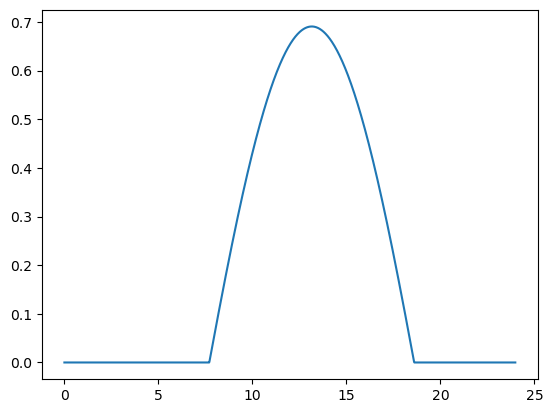

In [14]:
sol = solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel)

plt.plot(array,sol)

### Ny kode

In [51]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [52]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)

    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [53]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [54]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [55]:
energi_Wh = energi / 3600
energi_Wh

4.836338779081917

In [67]:
phi_panel = np.deg2rad(180)
energier = []

for vinkel in range(0, 91):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=60)
    energier.append(energi)

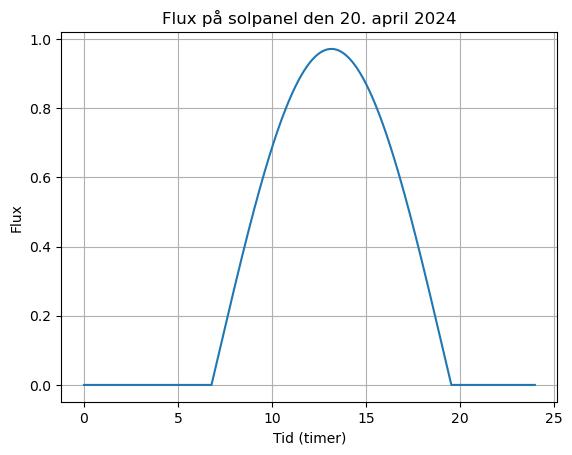

In [65]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

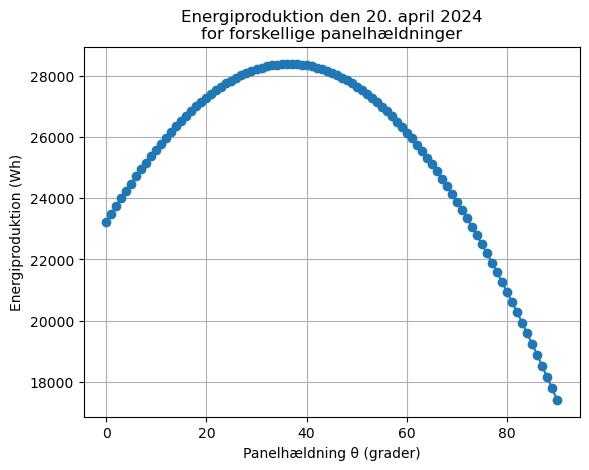

In [68]:
hældninger = np.arange(0, 91)  # 0° til 90°
plt.plot(hældninger, energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (Wh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()